In [22]:
# Change this to whatever your directory you're working from is - this should be
# the head level with Code and Data directories.
main_path = '/content/drive/MyDrive/DeepLearning_Summer2022/Final_Project/'

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import keras
import numpy as np
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
import copy
import random as python_random
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from google.colab import files
import sklearn.preprocessing
import scipy

import sys
import importlib

# set seeds
np.random.seed(768)
python_random.seed(869)
tf.random.set_seed(1234)

from google.colab import drive
drive.mount('/content/drive')

sys.path.append(main_path+"Code")
import vep_functions
importlib.reload(vep_functions)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<module 'vep_functions' from '/content/drive/MyDrive/DeepLearning_Summer2022/Final_Project/Code/vep_functions.py'>

In [24]:
# Check to make sure it's working correctly
vep_functions.aa_subs_input('S','C')

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [43]:
# Now, let's load our train and validate sets
data_dir = main_path+'Data/'
train_file = data_dir+'train_processed_clinvar_seqs_with_clusters_shuffled.csv'
val_file = data_dir+'validate_processed_clinvar_seqs_with_clusters_shuffled.csv'
test_file = data_dir+'test_processed_clinvar_seqs_with_clusters_shuffled.csv'

X_train, X_val, X_test, Y_train, Y_val, Y_test = vep_functions.model_1_process_input_and_output(train_file,val_file,test_file)

In [44]:
print(X_train.shape)
print(Y_train.shape)

(4868, 1, 40)
(4868, 1, 2)


In [45]:
# Build our specified model
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(1,40)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add in our code to save the 
checkpoint = ModelCheckpoint("aa_subs_best_model_epoch{epoch:02d}.ckpt", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', save_freq='epoch')

history = model.fit(X_train,
                    Y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    callbacks=[checkpoint])

results = model.evaluate(X_test, Y_test)
print(results)

Epoch 1/20
 1/10 [==>...........................] - ETA: 7s - loss: 0.7002 - accuracy: 0.4609
Epoch 1: val_accuracy improved from -inf to 0.65093, saving model to aa_subs_best_model_epoch01.ckpt
INFO:tensorflow:Assets written to: aa_subs_best_model_epoch01.ckpt/assets
10/10 [==============================] - 2s 140ms/step - loss: 0.6830 - accuracy: 0.5729 - val_loss: 0.6785 - val_accuracy: 0.6509
Epoch 2/20
 1/10 [==>...........................] - ETA: 0s - loss: 0.6697 - accuracy: 0.6543
Epoch 2: val_accuracy did not improve from 0.65093
10/10 [==============================] - 0s 7ms/step - loss: 0.6659 - accuracy: 0.6391 - val_loss: 0.6683 - val_accuracy: 0.6476
Epoch 3/20
 1/10 [==>...........................] - ETA: 0s - loss: 0.6514 - accuracy: 0.6699
Epoch 3: val_accuracy did not improve from 0.65093
10/10 [==============================] - 0s 6ms/step - loss: 0.6550 - accuracy: 0.6411 - val_loss: 0.6593 - val_accuracy: 0.6374
Epoch 4/20
 1/10 [==>...........................] - 

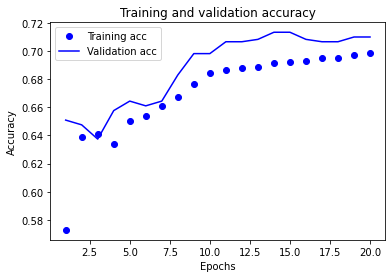

In [46]:
vep_functions.plot_acc(history)

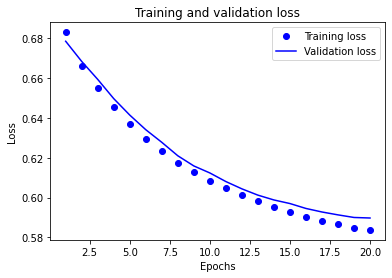

In [48]:
vep_functions.plot_loss(history)

In [47]:
x = vep_functions.calculate_shuffled_labels_accuracy_one_hot(model,X_test,Y_test)
print('Randomized accuracy on test set: {}'.format(x))
print('Model-trained accuracy on test set: {}'.format(results[1]))

Randomized accuracy on test set: 0.5826235093696763
Model-trained accuracy on test set: 0.7052810788154602


For curiosity's sake, let's compare our findings to the BLOSUM62 matrix (https://en.wikipedia.org/wiki/BLOSUM), which is essentially a matrix of transition probabilities for going from one amino acid to the other. This model was built using sequence alignments, and is currently the default setting for scoring sequences in the blastp program. (BLASTP is a bioinformatics go-to piece of software - it allows you to search for a protein sequence of interest against a database of sequences and return ones that score above a threshold. It's used for finding proteins that are similar (perhaps share homology) across multiple species, for one application. BLOSUM62, in this case, might represent a well-studied measure of how much penalty it might incur to substitute amino acids - which is somewhat analogous to our use case.

In [49]:
blosum = pd.read_csv(main_path+'Data/precursor_files/blosum62.csv')
blosum.head()

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
0,4,-1,-2,-2,0,-1,-1,0,-2,-1,-1,-1,-1,-2,-1,1,0,-3,-2,0
1,-1,5,0,-2,-3,1,0,-2,0,-3,-2,2,-1,-3,-2,-1,-1,-3,-2,-3
2,-2,0,6,1,-3,0,0,0,1,-3,-3,0,-2,-3,-2,1,0,-4,-2,-3
3,-2,-2,1,6,-3,0,2,-1,-1,-3,-4,-1,-3,-3,-1,0,-1,-4,-3,-3
4,0,-3,-3,-3,9,-3,-4,-3,-3,-1,-1,-3,-1,-2,-3,-1,-1,-2,-2,-1


In [50]:
# Get our ordered list of amino acids
aa_blosum = list(blosum.columns)

# Create a dictionary with amino acids as keys and their index as values
aa_blosum_ind = {}
for i in range(len(aa_blosum)):
  aa_blosum_ind[aa_blosum[i]] = i

# Enumerate all possible pairs of amino acids - note that we're allowing
# flexibility, e.g. aa1->aa2 does not necessarily equate to aa2->aa1
possible_pairs = [[aa1,aa2] for aa1 in aa_blosum for aa2 in aa_blosum if aa1 != aa2]
wt_vals = [x[0] for x in possible_pairs]
mut_vals = [x[1] for x in possible_pairs]
poss_pairs_x = np.array([vep_functions.aa_subs_input(w,m) for w,m in zip(wt_vals,mut_vals)])
print('Shape of input possible amino acid pairs: {}'.format(poss_pairs_x.shape))

nn_all_subs = model.predict(poss_pairs_x)

Shape of input possible amino acid pairs: (380, 1, 40)


In [51]:
# Let's double check which value corresponds to benign vs pathogenic
vep_functions.print_categorical_labels()

The categories are: [array(['benign', 'pathogenic'], dtype='<U10')]


Pearson R: (-0.30176868443580296, 1.928647039015955e-09)
Spearman R: SpearmanrResult(correlation=-0.3116281336820222, pvalue=5.296868708412108e-10)


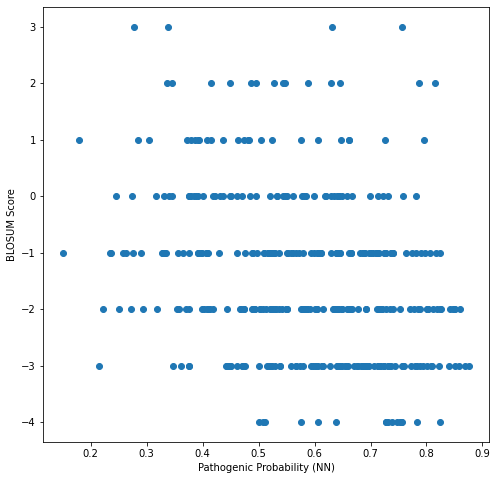

In [52]:
path_preds = [nn_all_subs[i][0][1] for i in range(len(nn_all_subs))]
blosum_preds = [blosum.iloc[aa_blosum_ind[possible_pairs[i][1]]][possible_pairs[i][0]] for i in range(len(possible_pairs))]
plt.figure(figsize=(8,8))
plt.xlabel('Pathogenic Probability (NN)')
plt.ylabel('BLOSUM Score')
plt.plot(path_preds,blosum_preds,'o')
print('Pearson R: {}'.format(scipy.stats.pearsonr(path_preds,blosum_preds)))
print('Spearman R: {}'.format(scipy.stats.spearmanr(path_preds,blosum_preds)))